In [1]:
import os
from glob import glob
import model.aotgan 
import torch
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from tqdm import tqdm
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from PIL import Image
from torch.utils.data import Dataset
import random
import numpy as np
from torch.utils.data import DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt
from loss1 import loss as loss_module

device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

2024-06-10 09:25:48.034037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 09:25:48.854792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
params={'image_size':512,
        'rates':[1, 2, 4, 8],
        'block_num':8,
        'model':'aotgan',
        'gan_type':"smgan",
        'lrg':2e-4,
        'lrd':2e-4,
        'beta1':0.5,
        'beta2':0.999,
        'batch_size':8,
        'epochs':1000,
        'data_path':'../../data/dataset/colon/',
        'num_workers':4,
        'rec_loss':'1*L1+250*Style+0.1*Perceptual'
        }
losses = list(params['rec_loss'].split("+"))
params['rec_loss'] = {}
for l in losses:
    weight, name = l.split("*")
    params['rec_loss'][name] = float(weight)

In [3]:
class CustomDataset(Dataset):
    def __init__(self, args,dataset):
        super(Dataset, self).__init__()
        self.w = self.h = args['image_size']

        # image and mask
        self.image_path =glob(args['data_path']+dataset+'/image/*.png')
        self.mask_path = [i.replace('/image','/mask') for i in self.image_path]
        self.trans_1 = transforms.Compose(
            [
                transforms.Resize((args['image_size'],args['image_size']), interpolation=transforms.InterpolationMode.NEAREST)
            ]
        )
    def trans(self,image_t,a):
        image_t=F.to_tensor(F.rotate(self.trans_1(image_t),a))
        return image_t

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, index):
        # load image
        image = Image.open(self.image_path[index]).convert("RGB")
        filename = os.path.basename(self.image_path[index])
        mask = Image.open(self.mask_path[index])
        mask = mask.convert("L")
        # augment
        angle=random.randint(0, 360)
        
        image = self.trans(image,angle) * 2.0 - 1.0
        mask = self.trans(mask,angle)
        
        return image, mask, filename
    
train_dataset=CustomDataset(params,'train')
test_dataset=CustomDataset(params,'test')
train_dataloader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
         shuffle=True, drop_last=True)
test_dataloader = DataLoader(
        test_dataset,
        batch_size=params['batch_size'],
         shuffle=True, drop_last=True)

In [4]:
netG =model.aotgan.InpaintGenerator(params).to(device)
optimG = torch.optim.Adam(netG.parameters(), lr=params['lrg'], betas=(params['beta1'], params['beta2']))

netD = model.aotgan.Discriminator().to(device)
optimD = torch.optim.Adam(netD.parameters(), lr=params['lrd'], betas=(params['beta1'], params['beta2']))
rec_loss_func = {key: getattr(loss_module, key)() for key, val in params['rec_loss'].items()}
adv_loss = getattr(loss_module, "smgan")()

/home/gil/anaconda3/envs/LeeYS/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gil/anaconda3/envs/LeeYS/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch: 1/1000 Step: 51 L1 loss : 0.5154 Style loss: 1.3682 Perceptual loss: 0.3809 advg loss: 0.0154 advd loss: 1.3314: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


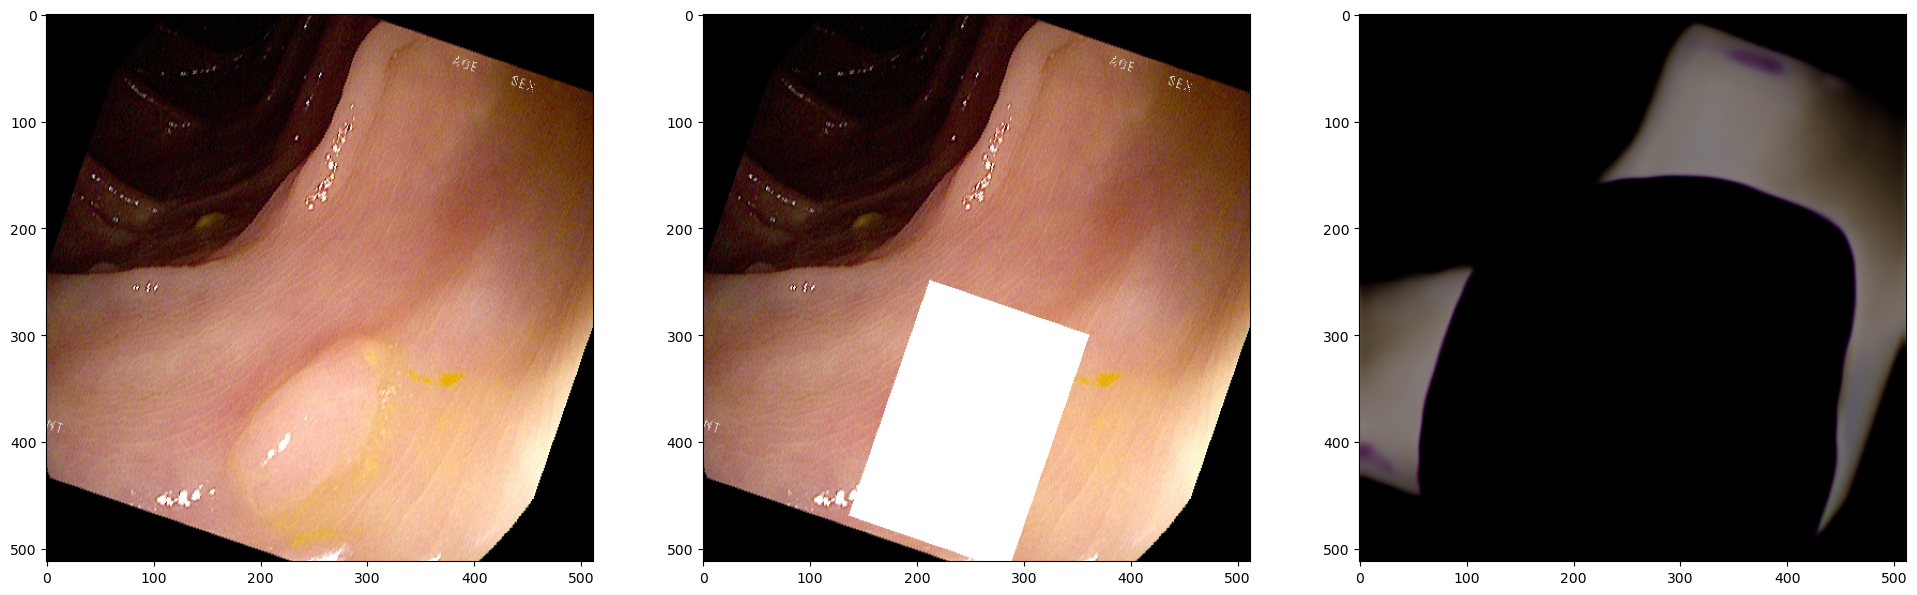

  0%|          | 0/50 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [5]:
plt_count=0
for epoch in range(params['epochs']):
    train=tqdm(train_dataloader)
    count=0
    train_L1_loss = 0.0 #예측된 값과 실제 값 사이의 절대값 차이의 평균 계산
    train_Style_loss = 0.0 # 네트워크가 생성한 이미지가 목표 스타일 이미지와 비슷한 텍스처, 색상 분포 및 시각적 패턴 비교
    train_Perceptual_loss = 0.0 #이미지의 전반적인 질감, 형태 및 콘텐츠의 유사성을 측정
    train_advg_loss = 0.0
    train_advd_loss = 0.0
    sum_loss= 1000.0
    for images, masks,filename in train:
        count+=1
        images, masks = images.to(device), masks.to(device)
        images_masked = (images * (1 - masks).float()) + masks
        pred_img = netG(images_masked, masks)
        comp_img = (1 - masks) * images + masks * pred_img
        losses = {}
        for name, weight in params['rec_loss'].items():
            losses[name] = weight * rec_loss_func[name](pred_img, images)
        dis_loss, gen_loss = adv_loss(netD, comp_img, images, masks)
        losses["advg"] = gen_loss*0.01
        # backforward
        optimG.zero_grad()
        optimD.zero_grad()
        sum(losses.values()).backward()
        optimG.step()
        losses["advd"] = dis_loss
        dis_loss.backward()
        
        optimD.step()
        train_L1_loss+=losses['L1'].item()
        train_Style_loss+=losses['Style'].item()
        train_Perceptual_loss+=losses['Perceptual'].item()
        train_advg_loss+=losses['advg'].item()
        train_advd_loss+=losses['advd'].item()
        train.set_description(f"epoch: {epoch+1}/{params['epochs']} Step: {count+1} L1 loss : {train_L1_loss/count:.4f} Style loss: {train_Style_loss/count:.4f} Perceptual loss: {train_Perceptual_loss/count:.4f} advg loss: {train_advg_loss/count:.4f} advd loss: {train_advd_loss/count:.4f}")
    if epoch % 50 ==5:
        torch.save(netG.state_dict(), '../../model/aot-model_colon/generator_'+str(plt_count)+'.pt')
        torch.save(netD.state_dict(), '../../model/aot-model_colon/discriminator_'+str(plt_count)+'.pt') 
        plt_count+=1
        ax=plt.figure(figsize=(24,8))
        ax.add_subplot(1,3,1)
        plt.imshow(np.transpose(images[0].cpu().detach().numpy(),(1,2,0))/2+0.5)
        ax.add_subplot(1,3,2)
        plt.imshow(np.transpose(images_masked[0].cpu().detach().numpy(),(1,2,0))/2+0.5)
        ax.add_subplot(1,3,3)
        plt.imshow(np.transpose(pred_img[0].cpu().detach().numpy(),(1,2,0))/2+0.5)
        plt.show()
        
    if sum_loss>sum(losses.values()):
        sum_loss=sum(losses.values())
        torch.save(netG.state_dict(), '../../model/aot-model_colon/generator_check.pt')
        torch.save(netD.state_dict(), '../../model/aot-model_colon/discriminator_check.pt')   